# Pixel classification

In [2]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_interactions import image_segmenter


## Load the data

In [4]:
from skimage import io
image = io.imread('../data/nuclei.tif')[:512,:512]

## Image features

In [18]:
from skimage import morphology, filters
import numpy as np
feat1 = np.diff(np.stack([filters.gaussian(image, s) for s in np.geomspace(1, 16, 5)]),1,0)
feat2 = np.stack([morphology.gray.erosion(image, morphology.disk(int(s))) for s in np.geomspace(1, 16, 5)])
feat3 = np.stack([morphology.gray.dilation(image, morphology.disk(int(s))) for s in np.geomspace(1, 16, 5)])
feat = np.concatenate([feat1,feat2,feat3], axis=0)
feat.shape


(14, 512, 512)

## Data annotation

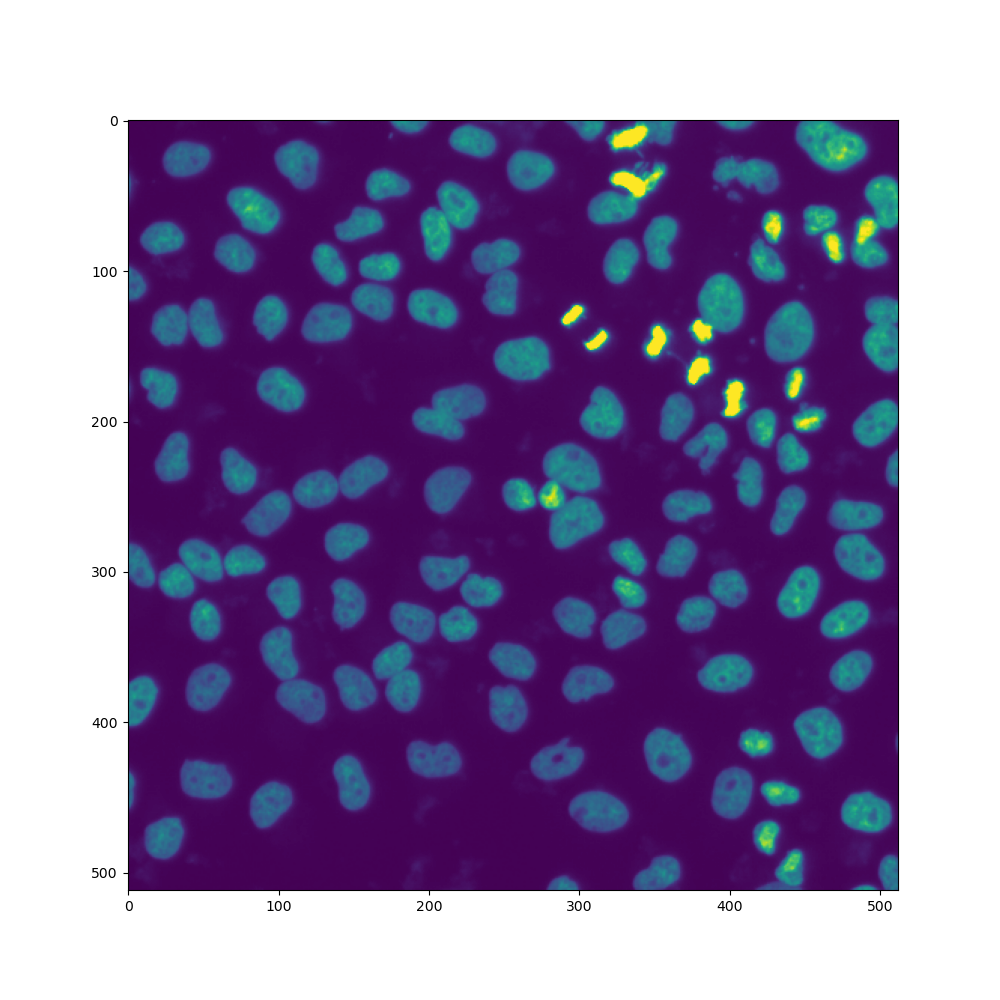

In [6]:
import ipywidgets as widgets

N_classes = 2
class_selector = widgets.Dropdown(options=list(range(1, N_classes + 1)), description="class")

def update(change):
    multi_class_segmenter.current_class = class_selector.value
    multi_class_segmenter.erasing = erasing_button.value

erasing_button = widgets.Checkbox(value=False, description="Erasing")
erasing_button.observe(update, names="value")

class_selector.observe(update, names="value")
multi_class_segmenter = image_segmenter(image, nclasses=3, mask_alpha=0.76)
display(widgets.HBox([erasing_button, class_selector]))
display(multi_class_segmenter)

## Run the classifier

Accuracy: 0.996 (0.002)


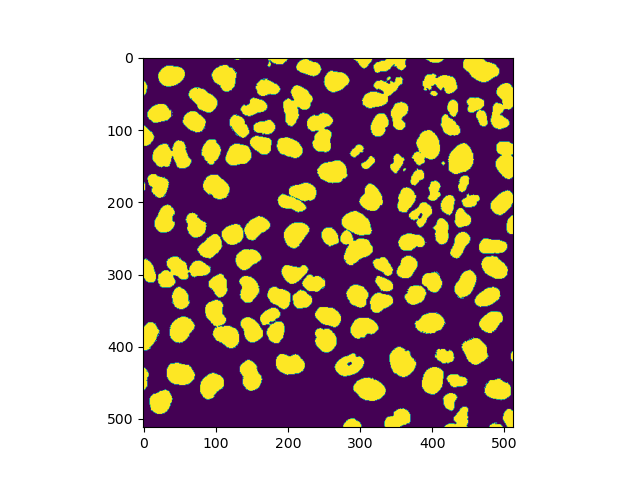

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

label = multi_class_segmenter.mask
X = feat[:,label > 0].T
y = label[label > 0] == 1
model = RandomForestClassifier()
model.fit(X, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
ypred = model.predict(feat.reshape((feat.shape[0],-1)).T)
plt.figure()
plt.imshow(ypred.reshape(image.shape));